Checkpoint: ../checkpoints/mip_ckpt/e2e_ep400.pt
  Keys   : ['means', 'log_scales', 'quaternions', 'log_intensities', 'epoch']
  Epoch  : 400
  Gaussians (K) : 50000
  Means range   : [-1.000, 1.000]
  Intensities   : [0.105, 0.993]
  Covariance built: torch.Size([50000, 3, 3])
  Aspect scales: [1.0, 0.7958179712295532, 0.12300123274326324]
  Camera: 256×256, fov=50.0°, β=50.0


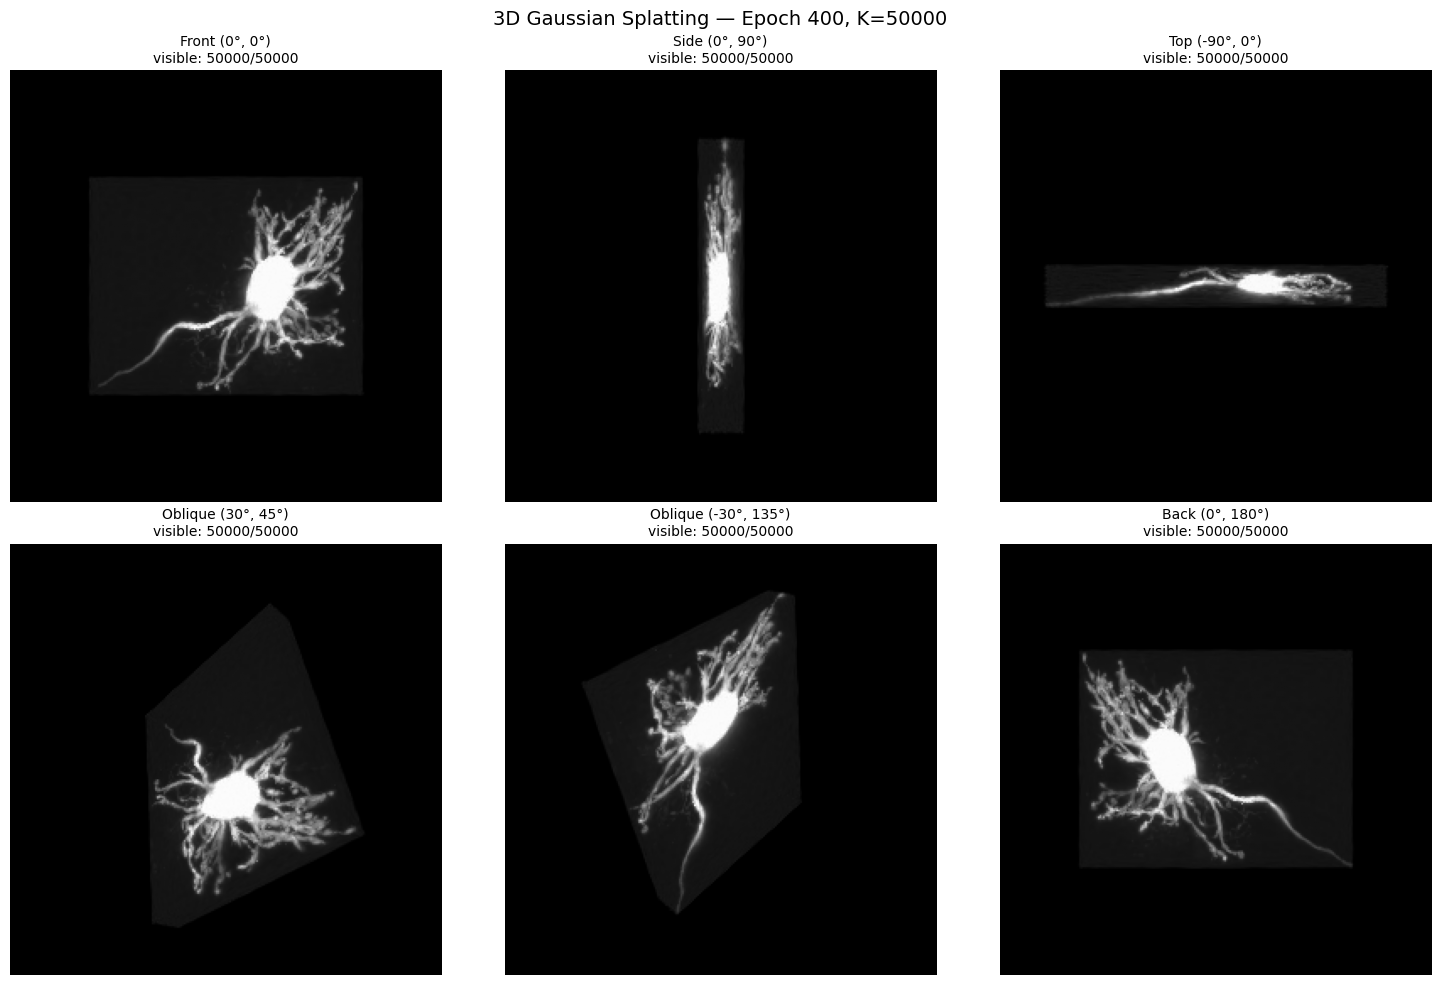

In [ ]:
"""
Load trained end-to-end 3D Gaussian Splatting model and render
synthesised images from multiple viewpoints.
"""
import sys, os, math
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# ── Make rendering.py importable ──
sys.path.insert(0, os.path.abspath("."))          # hisnegs/src/renderer
sys.path.insert(0, os.path.abspath(".."))          # hisnegs/src  (for utils)

from rendering import (
    Camera, GaussianParameters,
    compute_aspect_scales, apply_aspect_correction,
    render_mip_projection, render_gt_mip,
    load_volume, load_config, _orbit_pose,
    psnr_metric,
)

# ── 1. Load checkpoint ──────────────────────────────────────────────
ckpt_path = "../checkpoints/mip_ckpt/e2e_ep800.pt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

checkpoint = torch.load(ckpt_path, map_location=device)
print(f"Checkpoint: {ckpt_path}")
print(f"  Keys   : {list(checkpoint.keys())}")
print(f"  Epoch  : {checkpoint['epoch']}")

means           = checkpoint["means"].to(device)
log_scales      = checkpoint["log_scales"].to(device)
quaternions     = checkpoint["quaternions"].to(device)
log_intensities = checkpoint["log_intensities"].to(device)

K = means.shape[0]
print(f"  Gaussians (K) : {K}")
print(f"  Means range   : [{means.min():.3f}, {means.max():.3f}]")
print(f"  Intensities   : [{torch.sigmoid(log_intensities).min():.3f}, "
      f"{torch.sigmoid(log_intensities).max():.3f}]")

# ── 2. Build 3D covariances from (log_scales, quaternions) ──────────
scales = torch.exp(log_scales).clamp(1e-5, 1e2)          # (K, 3)

q = F.normalize(quaternions, p=2, dim=-1)
w, x, y, z = q[:, 0], q[:, 1], q[:, 2], q[:, 3]
R = torch.zeros(K, 3, 3, device=device)
R[:, 0, 0] = 1-2*(y*y+z*z);  R[:, 0, 1] = 2*(x*y-w*z);  R[:, 0, 2] = 2*(x*z+w*y)
R[:, 1, 0] = 2*(x*y+w*z);    R[:, 1, 1] = 1-2*(x*x+z*z); R[:, 1, 2] = 2*(y*z-w*x)
R[:, 2, 0] = 2*(x*z-w*y);    R[:, 2, 1] = 2*(y*z+w*x);   R[:, 2, 2] = 1-2*(x*x+y*y)

S2  = torch.diag_embed(scales ** 2)                       # (K, 3, 3)
cov = R @ S2 @ R.transpose(-2, -1)                        # Σ = R diag(s²) Rᵀ

intensities = torch.sigmoid(log_intensities)               # (K,)

print(f"  Covariance built: {cov.shape}")

# ── 3. Camera & aspect correction ───────────────────────────────────
cfg = load_config("config_splat.yml")

# Volume shape for aspect ratio (Z=100, Y=647, X=813)
vol_shape = (100, 647, 813)
aspect_scales = compute_aspect_scales(vol_shape).to(device)
print(f"  Aspect scales: {aspect_scales.tolist()}")

gaussians = GaussianParameters(means=means, covariances=cov, intensities=intensities)
gaussians = apply_aspect_correction(gaussians, aspect_scales)

res = 256
camera = Camera.from_config(cfg, width=res, height=res)
beta = cfg["training"]["beta_mip"]
print(f"  Camera: {res}×{res}, fov={cfg['camera']['fov_x_deg']}°, β={beta}")

# ── 4. Render synthesised images from several viewpoints ─────────────
viewpoints = [
    {"label": "Front (0°, 0°)",     "el": 0,   "az": 0},
    {"label": "Side (0°, 90°)",     "el": 0,   "az": 90},
    {"label": "Top (-90°, 0°)",     "el": -90, "az": 0},
    {"label": "Oblique (30°, 45°)", "el": 30,  "az": 45},
    {"label": "Oblique (-30°, 135°)", "el": -30, "az": 135},
    {"label": "Back (0°, 180°)",    "el": 0,   "az": 180},
]
radius = cfg["poses"]["radius"]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

with torch.no_grad():
    for i, vp in enumerate(viewpoints):
        R_cam, T_cam = _orbit_pose(vp["el"], vp["az"], radius)
        R_cam = R_cam.to(device)
        T_cam = T_cam.to(device)

        img, n_vis = render_mip_projection(
            gaussians, camera, R_cam, T_cam,
            beta=beta, chunk_size=4096,
        )

        img_np = img.detach().cpu().numpy()
        axes[i].imshow(img_np, cmap="gray", vmin=0, vmax=img_np.max() + 1e-8)
        axes[i].set_title(f"{vp['label']}\nvisible: {n_vis}/{K}", fontsize=10)
        axes[i].axis("off")

fig.suptitle(f"3D Gaussian Splatting — Epoch {checkpoint['epoch']}, K={K}", fontsize=14)
plt.tight_layout()
plt.show()


Camera: 1028×1028, fx=1102.3
Rendering 120 frames at 1028×1028, el=15.0°, az=[0°..360°) ...


  30/120 frames rendered
  60/120 frames rendered
  90/120 frames rendered
  120/120 frames rendered
All 120 frames rendered. Saving GIF...
GIF saved → ../checkpoints/mip_ckpt/e2e_rotate360_1028.gif  (15067 KB)


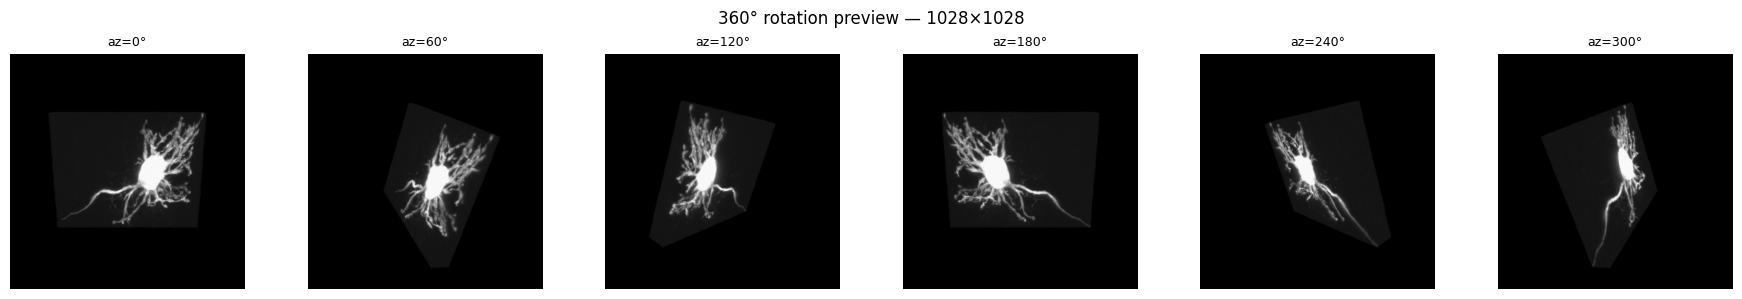

In [15]:
"""
Generate a 360° Y-axis rotation GIF of the 3D Gaussian Splatting model at 1028×1028.
"""
import imageio
from pathlib import Path

# ── Re-build camera at higher resolution ──
hi_res = 1028
camera_hi = Camera.from_config(cfg, width=hi_res, height=hi_res)
print(f"Camera: {hi_res}×{hi_res}, fx={camera_hi.fx:.1f}")

n_frames = 120
fps = 24
elevation = 15.0
out_path = Path("../checkpoints/mip_ckpt/e2e_rotate360_1028.gif")
out_path.parent.mkdir(parents=True, exist_ok=True)

frames = []
azimuths = np.linspace(0, 360, n_frames, endpoint=False)

print(f"Rendering {n_frames} frames at {hi_res}×{hi_res}, el={elevation}°, az=[0°..360°) ...")

with torch.no_grad():
    for i, az in enumerate(azimuths):
        R_cam, T_cam = _orbit_pose(elevation, float(az), radius)
        R_cam = R_cam.to(device)
        T_cam = T_cam.to(device)

        img, _ = render_mip_projection(
            gaussians, camera_hi, R_cam, T_cam,
            beta=beta, chunk_size=4096,
        )

        img_np = img.detach().cpu().numpy()
        img_np = np.clip(img_np / (img_np.max() + 1e-8), 0, 1)
        frame = (img_np * 255).astype(np.uint8)
        frames.append(frame)

        if (i + 1) % 30 == 0:
            print(f"  {i+1}/{n_frames} frames rendered")

print(f"All {n_frames} frames rendered. Saving GIF...")
imageio.mimsave(str(out_path), frames, fps=fps, loop=0)
print(f"GIF saved → {out_path}  ({out_path.stat().st_size / 1024:.0f} KB)")

# Preview strip
preview_idx = list(range(0, n_frames, n_frames // 6))
fig, axes = plt.subplots(1, len(preview_idx), figsize=(18, 3))
for j, idx in enumerate(preview_idx):
    axes[j].imshow(frames[idx], cmap="gray")
    axes[j].set_title(f"az={azimuths[idx]:.0f}°", fontsize=9)
    axes[j].axis("off")
fig.suptitle(f"3D Gaussian Splatting — 360° rotation preview ({hi_res}×{hi_res})", fontsize=12)
plt.tight_layout()
plt.show()
